# A study of some techniques for Monte Carlo Sampling

We have so far seen several examples of Bayesian Modeling using PyMC3. The output here is always in the form of posterior Monte Carlo samples. These samples can be used to approximate the underlying actual posterior distributions. We shall look closely at two standard sampling techniques for generating posterior samples: 
1. Rejection Sampling
2. Gibbs Sampling

## Rejection Sampling

Rejection sampling is a very old method for obtaining Monte Carlo Samples. Suppose the goal is to obtain samples from a density $f_{\text{Target}}(u)$. Rejection sampling provides an algorithm for generating samples from $f_{\text{Target}}(u)$ using another density $f_{\text{Proposal}}(u)$. This proposal density should satisfy the following two properties: 
1. Obtaining samples from $f_{\text{Proposal}}(u)$ should be easy. 
2. There must exist a positive real number $M$ such that $$f_{\text{Target}}(u) \leq M f_{\text{Proposal}}(u)$$ for all values of $u$. Although the method will work, in principle, for any positive $M$ satisfying the above condition, it becomes extremely inefficient if $M$ gets large as will be clear below. So we want $M$ to satisfy the above condition and also to be not too large. 

Rejection Sampling is based on the following very simple (Bayesian) fact. Consider the following Bayesian model: 
\begin{align*}
    \text{Prior}: \Theta \sim f_{\text{Proposal}} ~~~ \text{ and } ~~~ \text{Likelihood}: Y \mid \Theta = u \sim \text{Bernoulli} \left(\frac{f_{\text{Target}}(u)}{M f_{\text{Proposal}}(u)} \right)
\end{align*}
So in this model, the unknown parameter $\Theta$ has the prior density $f_{\text{Proposal}}$. The data is binary and the likelihood is given by the Bernoulli distribution with parameter $\frac{f_{\text{Target}}(u)}{M f_{\text{Proposal}}(u)}.$ Note that the Bernoulli parameter should be always between 0 and 1 which is why we need the condition $f_{\text{Target}}(u) \leq M f_{\text{Proposal}}(u)$ for all values of $u$. The key fact underlying Rejection Sampling is that the posterior density of $\Theta$ in this model given $Y = 1$ is exactly $f_{\text{Target}}$:
\begin{align*}
   \Theta \mid Y = 1  ~~ \sim f_{\text{Target}}
\end{align*}
This is proved by a simple application of Bayes rule as follows: 
\begin{align*}
    f_{\Theta \mid Y = 1}(u) &= \frac{f_{\Theta}(u) \mathbb{P}\{Y = 1 \mid \Theta = u\}}{\int f_{\Theta}(v) \mathbb{P}\{Y = 1 \mid \Theta = v\} dv} \\
    &= \frac{f_{\text{Proposal}}(u) \frac{f_{\text{Target}}(u)}{M f_{\text{Proposal}}(u)}}{\int f_{\text{Proposal}}(v) \frac{f_{\text{Target}}(v)}{M f_{\text{Proposal}}(v)} dv} \\
    &= \frac{\frac{f_{\text{Target}}(u)}{M}}{\int \frac{f_{\text{Target}}(v)}{M } dv} = f_{\text{Target}}(u). 
\end{align*}

Based on this idea, the algorithm for Rejection Sampling goes as follows. 
1. Generate lots of samples $(\Theta^{(i)}, Y^{(i)}$ from the probability model described above. In other words, take $\Theta^{(i)} \sim f_{\text{Proposal}}$ and $Y^{(i)} \mid \Theta = \Theta^{(i)} \sim  \text{Bernoulli} \left(\frac{f_{\text{Target}}(\Theta^{(i)})}{M f_{\text{Proposal}}(\Theta^{(i)})} \right)$
2. Based on the samples, approximate the distribution of $\Theta \mid Y = 1$. This is done by discarding (or **rejecting**) the samples for which $Y^{(i)} = 0$ and keeping only the ones with $Y^{(i)} = 1$. The $\Theta^{(i)}$'s in the remaining samples approximate $f_{\text{Target}}$.

Here is how this algorithm works for sampling from Beta distributions. Here $f_{\text{Target}}$ is a Beta density and $f_{\text{Proposal}}$ is the uniform density. 

In [9]:
import numpy as np
import matplotlib.pyplot as plt

4998


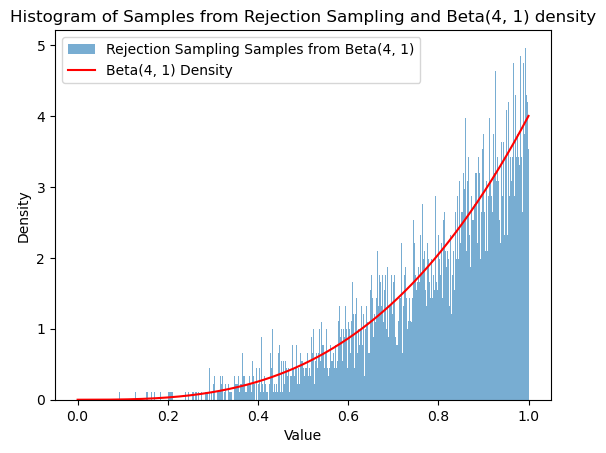

In [10]:
#Rejection sampling for generating samples from Beta(4, 1):
#Our proposal distribution will be Uniform[0, 1]
#The value of M can be taken to be the largest value of the density. 
M = 4
N = 20000 #this is the number of proposal samples that we will generate
prior_samples = np.random.rand(N)
p_prior_samples = prior_samples ** 3
Y_samples = np.random.binomial(n = 1, p = p_prior_samples)
posterior_samples = prior_samples[Y_samples == 1]
print(len(posterior_samples))
plt.hist(posterior_samples, bins = 500, density = True, alpha = 0.6, label = 'Rejection Sampling Samples from Beta(4, 1)') 
x = np.linspace(0, 1, 1000)
from scipy.stats import beta
pdf_values = beta.pdf(x, 4, 1)
plt.plot(x, pdf_values, 'r-', label = 'Beta(4, 1) Density')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.title('Histogram of Samples from Rejection Sampling and Beta(4, 1) density')
plt.show()
#The match between the histogram and the true density is not bad but we are only 
#getting about 1/4 of the total samples (others are rejected because of Y = 0).

2595


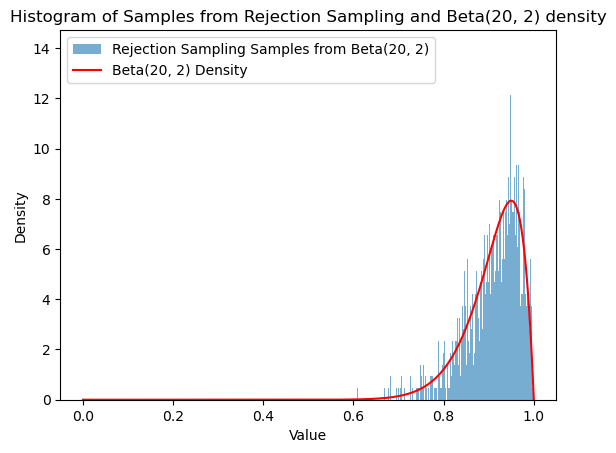

In [11]:
#Rejection sampling for generating samples from Beta(20, 2):
#Our proposal distribution will be Uniform[0, 1]
#The value of M can be taken to be anything larger than the largest value of the density. 
M = 8
N = 20000 #this is the number of proposal samples that we will generate
prior_samples = np.random.rand(N)
p_prior_samples = 420 * (prior_samples ** 19) * (1 - prior_samples) * (1/8)
Y_samples = np.random.binomial(n = 1, p = p_prior_samples)
posterior_samples = prior_samples[Y_samples == 1]
print(len(posterior_samples))
plt.hist(posterior_samples, bins = 500, density = True, alpha = 0.6, label = 'Rejection Sampling Samples from Beta(20, 2)') 
x = np.linspace(0, 1, 1000)
from scipy.stats import beta
pdf_values = beta.pdf(x, 20, 2)
plt.plot(x, pdf_values, 'r-', label = 'Beta(20, 2) Density')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.title('Histogram of Samples from Rejection Sampling and Beta(20, 2) density')
plt.show()
#The match between the histogram and the true density is not bad but we are only 
#getting about 1/8 of the total samples (others are rejected because of Y = 0).

In general, the marginal probability of $Y = 1$ in the rejection sampling Bayesian model equals $1/M$: 
\begin{align*}
  \mathbb{P} \{Y = 1\} &= \int f_{\Theta}(v) \mathbb{P}\{Y = 1 \mid \Theta = v\} dv \\ &= \int f_{\text{Proposal}}(v) \frac{f_{\text{Target}}(v)}{M f_{\text{Proposal}}(v)} dv = \frac{1}{M} \int f_{\text{Target}}(v) dv = \frac{1}{M}
\end{align*}
So if $N$ samples $(\Theta^{(i)}, Y^{(i)})$ are originally generated from the prior (proposal density), then only about $N/M$ will have $Y^{(i)} = 1$. Thus we can expect to have about $N/M$ samples from the posterior (target density). Thus if $M$ is large, we will have very few samples from the target density. The main trick in Rejection Sampling therefore is to choose the proposal density so that $M$ is not too large (this, of course, may not be always possible because the proposal density also needs to be such that samples can be generated from it easily). This is the reason why Rejection Sampling is inefficient in most practical instances. 

# Gibbs Sampling

The Gibbs Sampler is a very standard method for drawing posterior samples. The goal is to generate samples from a target density $f_{\text{Target}}(u)$. The Gibbs sampler is applicable when $u$ is a multivariate vector. To start with, let us assume that $u$ is bivariate consisting of two components $u_1$ and $u_2$ i.e., $u = (u_1, u_2)$, and that $f_{\text{Target}}(u_1, u_2)$ is the joint density of two random variables $U_1$ and $U_2$. The Gibbs sampler will produce samples of the form: 
\begin{align*}
   (u_1^{(0)}, u_2^{(0)}) \rightarrow (u_1^{(1)}, u_2^{(1)}) \rightarrow (u_1^{(2)}, u_2^{(2)}) \rightarrow \dots \rightarrow (u_1^{(T)}, u_2^{(T)})
\end{align*}
for a large $T$, by going through the following steps: 
1. Initialize at arbitrary $u_1^{(0)}$ and $u_2^{(0)}$. Repeat the following for $t = 0, 1, 2, \dots$
2. Given the current sample $(u_1^{(t)}, u_2^{(t)})$,
   1. draw $u_1^{(t+1)}$ randomly from the conditional distribution of $U_1$ given $U_2 = u_2^{(t)}$. In other words $$u_1^{(t+1)} \sim        \text{density of } U_1 \mid U_2 = u_2^{(t)}.$$
   2. draw $u_2^{(t+1)}$ randomly from the conditional distribution of $U_2$ given $U_1 = u_1^{(t+1)}$. In other words $$u_2^{(t+1)} \sim    \text{density of } U_2 \mid U_1 = u_1^{(t+1)}.$$

The Gibbs sampler is a very simple and intuitive algorithm. It works by repeatedly sampling from the conditional distributions $U_1 \mid U_2 = u_2$ and $U_2 \mid U_1 = u_1$ by using the most recent values for $u_1$ and $u_2$. Let us illustrate how the Gibbs sampler works by solving the problem on normal mean estimation from last lecture. 

Here is the normal mean estimation problem from last lecture. A simple experiment to measure the length of an object led to the following 15 measurements: $17.62, 17.61, 17.61, 17.62, 17.62, 17.615, 17.615, 17.625, 17.61, 17.62, 17.62, 17.605, 17.61, 17.62, 17.61.$  What is the best estimate for the length of this object?

The usual analysis of this problem first assumes that $$Y_1, \dots, Y_n \overset{\text{i.i.d}}{\sim} N(\theta, \sigma^2).$$ One then estimates $\theta$ by the sample mean: $\bar{Y} = \frac{Y_1 + \dots + Y_n}{n}$. After this, one uses
\begin{align*}
    \bar{Y} \sim N\left(\theta, \frac{\sigma^2}{n} \right) \text{ or, equivalently } \frac{\bar{Y} - \theta}{\sqrt{\frac{\sigma^2}{n}}} = \frac{\sqrt{n}(\bar{Y} - \theta)}{\sigma}\sim N(0, 1). 
\end{align*}
The above distributional statement cannot be used for constructing confidence intervals for $\theta$ because $\sigma$ is unknown. One then estimates $\sigma$ as
\begin{align*}
   \hat{\sigma} := \sqrt{\frac{1}{n-1} \sum_{i=1}^n (Y_i - \bar{Y})^2}, 
\end{align*}
and uses the following fact: 
\begin{align*}
    \frac{\sqrt{n}(\bar{Y} - \theta)}{\hat{\sigma}}\sim \mathbf{t}_{n-1}
\end{align*}
where $\mathbf{t}_{n-1}$ is the Student $t$-distribution  with $n-1$ degrees of freedom. From this, one can construct a $100(1-\alpha)$ confidence interval for $\theta$ as:
\begin{align*}
   \left[\bar{Y} - \frac{\sigma}{\sqrt{n}} \mathbf{t}_{n-1, \alpha/2}, \bar{Y} + \frac{\sigma}{\sqrt{n}} \mathbf{t}_{n-1, \alpha/2}  \right]
\end{align*}
where $\mathbf{t}_{n-1, \alpha/2}$ is the point on the positive real line to the right of which the $\mathbf{t}_{n-1}$ distribution assigns probability $\alpha/2$. 

In [12]:
import numpy as np
n = 15
y_obs = np.array([17.62, 17.61, 17.61, 17.62, 17.62, 17.615, 17.615, 17.625, 17.61, 17.62, 17.62, 17.605, 17.61, 17.62, 17.61])
ybar = np.mean(y_obs)
sighat = np.std(y_obs, ddof = 1)
display(ybar, sighat)
alpha = 0.05
from scipy.stats import t
t_critical_value = t.ppf(1 - alpha/2, n-1)
print(t_critical_value)
#95% confidence interval
ci_lower = ybar - sighat*(1/np.sqrt(n))*t_critical_value
ci_upper = ybar + sighat*(1/np.sqrt(n))*t_critical_value
display([ci_lower, ci_upper])

17.615333333333336

0.005814595756329882

2.1447866879169273


[17.61211331753182, 17.618553349134853]

In our Bayesian analysis of this problem, there were two parameters: $\theta$ which is the unknown length of the object, and $\sigma$ which represents the uncertainty in each individual measurement. We used the following prior and likelihood: 
\begin{align*}
  \text{Prior: } \theta \sim \text{Uniform}[-80, 80] ~~ \text{ and } ~~ \log \sigma \sim \text{Uniform}[-10, 10]
\end{align*}
\begin{align*}
  \text{Likelihood: } y_1, \dots, y_n \mid \theta, \sigma \overset{\text{i.i.d}}{\sim} N(\theta, \sigma^2)
\end{align*}
We then specified this model in PyMC and obtained posterior samples from PyMC. 

In [13]:
import pymc as pm
import arviz as az
n = 15
y_obs = np.array([17.62, 17.61, 17.61, 17.62, 17.62, 17.615, 17.615, 17.625, 17.61, 17.62, 17.62, 17.605, 17.61, 17.62, 17.61])
measurement_model = pm.Model()
with measurement_model:
    theta = pm.Uniform("theta", lower = -80, upper = 80)
    log_sigma = pm.Uniform("log_sigma", lower = -10, upper = 10)
    sigma = pm.Deterministic("sigma", pm.math.exp(log_sigma))
    Y = pm.Normal("Y", mu = theta, sigma = sigma, observed=y_obs)
    #Sample from posterior:
    idata = pm.sample(2000, chains = 2, return_inferencedata = True) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, log_sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [14]:
#The posterior samples can be used to estimate theta (and sigma) along with uncertainty quantification as follows: 
theta_samples = idata.posterior['theta'].values.flatten()
log_sigma_samples = idata.posterior['log_sigma'].values.flatten()
sigma_samples = np.exp(log_sigma_samples)
#Our best estimate of the unknown length can be taken to be the mean of the posterior samples for theta:
thetamean = np.mean(theta_samples)
display(thetamean)
#A 95% interval for theta based on the posterior samples is computed as follows:
lower_limit_theta = np.percentile(theta_samples, 2.5)
upper_limit_theta = np.percentile(theta_samples, 97.5)
display([lower_limit_theta, upper_limit_theta])
#This interval should be very similar to the confidence interval for theta derived previously

17.615362884991576

[17.61221947292516, 17.618538727330375]

We now obtain posterior samples for $U_1 := \theta$ and $U_2 := \sigma$ by the Gibbs sampling algorithm (instead of using PyMC). In other words, we need to sample from the target density $f_{\theta, \sigma \mid \text{data}}(t, s)$. Note that, by Bayes rule, this posterior density equals: 
\begin{align*}
   f_{\theta, \sigma \mid \text{data}}(t, s) = \frac{f_{\theta, \sigma}(t, s) f_{\text{data} \mid \theta = t, \sigma = s}(\text{data})}{\int \int f_{\theta, \sigma}(t, s) f_{\text{data} \mid \theta = t, \sigma = s}(\text{data}) dt ds}
\end{align*}
The numerator above is simply $prior \times likelihood$ and the denominator is the normalizing constant which makes the density (over $t, s$) integrate to one. One often ignores the denominator and writes the above relation using the "proportional to" sign ($\propto$) as:
\begin{align*}
   f_{\theta, \sigma \mid \text{data}}(t, s) \propto \text{Prior} \times \text{Likelihood} = f_{\theta, \sigma}(t, s) f_{\text{data} \mid \theta = t, \sigma = s}(\text{data})
\end{align*}
The prior is given by
\begin{align*}
  f_{\theta, \sigma}(t, s) &= f_{\theta}(t) \times f_{\sigma}(s), ~~\text{assuming prior independence betweeen } \theta ~ \text{ and } ~\sigma \\
  &= \frac{I\{-80 \leq t \leq 80\}}{160} \times f_{\log \sigma}(\log s) \frac{d \log s}{ds}, ~~ \text{ where the identity } f_{\sigma}(s) = f_{\log \sigma}(\log s) \frac{d \log s}{ds} ~ \text{ follows from the Jacobian formula} \\
  &= \frac{I\{-80 \leq t \leq 80\}}{160} \times \frac{I\{-10 \leq \log s \leq 10\}}{20} \frac{1}{s} \\
  &= \frac{I\{-80 \leq t \leq 80\}}{160} \times \frac{I\{\exp(-10) \leq s\leq \exp(10)\}}{20} \frac{1}{s} \\
  &\propto I\{-80 \leq t \leq 80\} I\{\exp(-10) \leq s \leq \exp(10)\} \frac{1}{s}
\end{align*}
where, in the last step, we ignored the constant factors $160$ and $20$ by replacing the equality sign with the proportional sign. 

The Likelihood is given by
\begin{align*}
   f_{\text{data} \mid \theta = t, \sigma = s}(\text{data}) &= f_{y_1, \dots, y_n \mid \theta = t, \sigma = s}(y_1, \dots, y_n) \\
   &= f_{y_1 \mid \theta = t, \sigma = s}(y_1) \times f_{y_2 \mid \theta = t, \sigma = s}(y_2) \times \dots \times f_{y_n \mid \theta = t, \sigma = s}(y_n) \\
   &= \frac{1}{s\sqrt{2\pi}} \exp \left(-\frac{(y_1 - t)^2}{2s^2} \right) \times \frac{1}{s\sqrt{2\pi}} \exp \left(-\frac{(y_2 - t)^2}{2s^2} \right) \times \dots \times \frac{1}{s\sqrt{2\pi}} \exp \left(-\frac{(y_n - t)^2}{2s^2} \right) \\
   &= \frac{1}{s^n (\sqrt{2 \pi})^n} \exp \left(-\frac{(y_1 - t)^2 + (y_2 - t)^2 + \dots + (y_n - t)^2}{2s^2} \right).
\end{align*}
The constant factor $\frac{1}{(\sqrt{2\pi})^n}$ does not depend on the parameters $t, s$ and so it can be ignored in proportionality leading to
\begin{align*}
   f_{\text{data} \mid \theta = t, \sigma = s}(\text{data}) \propto \frac{1}{s^n}  \exp \left(-\frac{(y_1 - t)^2 + (y_2 - t)^2 + \dots + (y_n - t)^2}{2s^2} \right).
\end{align*}
Combining the above derived formulae for the prior and likelihood, we obtain the posterior as:
\begin{align*}
& f_{\theta, \sigma \mid \text{data}}(t, s) \\ &\propto \text{Prior} \times \text{Likelihood} \\
&\propto I\{-80 \leq t \leq 80\} I\{\exp(-10) \leq s \leq \exp(10)\} \frac{1}{s} \times \frac{1}{s^n}  \exp \left(-\frac{(y_1 - t)^2 + (y_2 - t)^2 + \dots + (y_n - t)^2}{2s^2} \right) \\
&=  I\{-80 \leq t \leq 80\} I\{\exp(-10) \leq s \leq \exp(10)\} \frac{1}{s^{n+1}}  \exp \left(-\frac{(y_1 - t)^2 + (y_2 - t)^2 + \dots + (y_n - t)^2}{2s^2} \right).
\end{align*}
The above relation is true up to proportionality. If we want to have equality, we have to normalize the right hand side leading to:
\begin{align*}
  f_{\theta, \sigma \mid \text{data}}(t, s) = \frac{I\{-80 \leq t \leq 80\} I\{\exp(-10) \leq s \leq \exp(10)\} \frac{1}{s^{n+1}}  \exp \left(-\frac{(y_1 - t)^2 + (y_2 - t)^2 + \dots + (y_n - t)^2}{2s^2} \right)}{\int_{-80}^{80} \int_{e^{-10}}^{e^{10}} \frac{1}{s^{n+1}}  \exp \left(-\frac{(y_1 - t)^2 + (y_2 - t)^2 + \dots + (y_n - t)^2}{2s^2} \right) dt ds}
\end{align*}
We now use the Gibbs sampler to generate samples $(t^{(0)}, s^{(0)})$, $(t^{(1)}, s^{(1)})$, $\dots$, $(t^{(T)}, s^{(T)})$ from this somewhat complicated looking bivariate density. The main thing to figure out for Gibbs are the conditional distributions $\theta \mid \sigma = s, \text{data}$ and $\sigma \mid \theta = t, \text{data}$. For $f_{\theta \mid \sigma = s, \text{data}}(t)$, write
\begin{align*}
   f_{\theta \mid \sigma = s, \text{data}}(t) &\propto f_{\theta, \sigma \mid \text{data}}(t, s) \\
   &\propto I\{-80 \leq t \leq 80\} I\{\exp(-10) \leq s \leq \exp(10)\} \frac{1}{s^{n+1}}  \exp \left(-\frac{(y_1 - t)^2 + (y_2 - t)^2 + \dots + (y_n - t)^2}{2s^2} \right).
\end{align*}
$f_{\theta \mid \sigma = s, \text{data}}(t)$ is a density in the variable $t$ which means that any multiplicative factor not depending on $t$ can be ignored in proportionality. We thus get
\begin{align*}
   f_{\theta \mid \sigma = s, \text{data}}(t) &\propto f_{\theta, \sigma \mid \text{data}}(t, s) \\
   &\propto I\{-80 \leq t \leq 80\} \exp \left(-\frac{(y_1 - t)^2 + (y_2 - t)^2 + \dots + (y_n - t)^2}{2s^2} \right).
\end{align*}
Using the elementary equality
\begin{align*}
   (y_1 - t)^2 + (y_2 - t)^2 + \dots + (y_n - t)^2 = (y_1 - \bar{y})^2 + (y_2 - \bar{y})^2 + \dots + (y_n - \bar{y})^2 + n(\bar{y} - t)^2,
\end{align*}
we get
\begin{align*}
   f_{\theta \mid \sigma = s, \text{data}}(t) 
   &\propto I\{-80 \leq t \leq 80\} \exp \left(-\frac{(y_1 - \bar{y})^2 + (y_2 - \bar{y})^2 + \dots + (y_n - \bar{y})^2 + n(\bar{y} - t)^2}{2s^2} \right) \\
   &= I\{-80 \leq t \leq 80\} \exp \left(-\frac{(y_1 - \bar{y})^2 + (y_2 - \bar{y})^2 + \dots + (y_n - \bar{y})^2}{2 s^2} \right) \exp \left(-\frac{n(\bar{y} - t)^2}{2s^2} \right)
\end{align*}
The multiplicative factor $\exp \left(-\frac{(y_1 - \bar{y})^2 + (y_2 - \bar{y})^2 + \dots + (y_n - \bar{y})^2}{2 s^2} \right)$ does not depend on $t$ and can be ignored in proportionality leading to the simpler expression: 
\begin{align*}
f_{\theta \mid \sigma = s, \text{data}}(t) \propto I\{-80 \leq t \leq 80\} \exp \left(-\frac{n(\bar{y} - t)^2}{2s^2} \right) =  I\{-80 \leq t \leq 80\} \exp \left(-\frac{(t - \bar{y})^2}{2\frac{s^2}{n}} \right)
\end{align*}
In other words, $\theta \mid \sigma = s, \text{data}$ is the normal distribution $N(\bar{y}, \frac{s^2}{n})$ conditioned to lie between $[-80, 80]$. Generating a random sample from this distribution is easy: sample from $N(\bar{y}, \frac{s^2}{n})$. Keep the sample unless it lies outside $[-80, 80]$. If it lies outside $[-80, 80]$, just throw this sample away and repeat. Note that, in our dataset, $\bar{y} = 17.615$ and $s^2/n$ will be generally small, so the samples from $N(\bar{y}, s^2/n)$ will almost always lie between $-80$ and $80$. 

For the other conditional $\sigma \mid \theta = t, \text{data}$, write
\begin{align*}
   f_{\sigma \mid \theta = t, \text{data}}(s) &\propto f_{\theta, \sigma \mid \text{data}}(t, s) \\
   &\propto I\{-80 \leq t \leq 80\} I\{\exp(-10) \leq s \leq \exp(10)\} \frac{1}{s^{n+1}}  \exp \left(-\frac{(y_1 - t)^2 + (y_2 - t)^2 + \dots + (y_n - t)^2}{2s^2} \right).
\end{align*}
Now we can ignore the factor $I\{-80 \leq t \leq 80\}$ which does not depend on $s$. We then get
\begin{align*}
   f_{\sigma \mid \theta = t, \text{data}}(s)
   &\propto  I\{\exp(-10) \leq s \leq \exp(10)\} \frac{1}{s^{n+1}}  \exp \left(-\frac{(y_1 - t)^2 + (y_2 - t)^2 + \dots + (y_n - t)^2}{2s^2} \right).
\end{align*}
To parse this density, first of all, we can replace the somewhat complicated indicator function by the simpler $I\{s > 0\}$ because $\exp(-10) \approx 0$ and $\exp(10) \approx \infty$. The rest of the terms involve a power term and an exponential term resembling a Gamma density. However, this seems like a Gamma density in $1/s^2$ as the exponent involves $1/s^2$. We can convert it back to a regular Gamma density by calculating the density of $1/\sigma^2$ using the Jacobian formula: 
\begin{align*}
   f_{\frac{1}{\sigma^2} \mid \theta = t, \text{data}}(u) = f_{\sigma \mid \theta = t, \text{data}}\left(\sqrt{\frac{1}{u}} \right)\frac{1}{2u^{3/2}} \propto I\{u > 0\} u^{(n-2)/2}\exp \left(-\frac{(y_1 - t)^2 + (y_2 - t)^2 + \dots + (y_n - t)^2}{2} u \right)
\end{align*}
We thus get
\begin{align*}
   \frac{1}{\sigma^2} \mid \theta = t, \text{data} \sim \text{Gamma} \left(\text{shape}  = \frac{n}{2}, \text{rate} = \frac{(y_1 - t)^2 + (y_2 - t)^2 + \dots + (y_n - t)^2}{2} \right)
\end{align*}


In [15]:
import numpy as np
n = 15
y_obs = np.array([17.62, 17.61, 17.61, 17.62, 17.62, 17.615, 17.615, 17.625, 17.61, 17.62, 17.62, 17.605, 17.61, 17.62, 17.61])
T = 4000

#Initialize
theta_0 = np.mean(y_obs)
sigma_0 = np.std(y_obs, ddof = 1)

#Create a list to store pairs (theta, sigma)
theta_sigma_pairs = [(theta_0, sigma_0)]

#Run the Gibbs steps
for t in range(1, T+1):
    s = theta_sigma_pairs[t-1][1]
    theta_t = np.random.normal(np.mean(y_obs), np.sqrt(s**2/n))
    deviations = [(y_i - theta_t)**2 for y_i in y_obs]
    u_t = np.random.gamma(n/2, 2/sum(deviations))
    sigma_t = 1/np.sqrt(u_t)
    theta_sigma_pairs.append((theta_t, sigma_t))

theta_values = [pair[0] for pair in theta_sigma_pairs]
sigma_values = [pair[1] for pair in theta_sigma_pairs]
theta_Gibbs = np.array(theta_values)
sigma_Gibbs = np.array(sigma_values)

In [16]:
#Our best estimate of theta can be taken to be the mean of the posterior samples for theta:
thetamean_Gibbs = np.mean(theta_Gibbs)
display(thetamean_Gibbs)
#A 95% interval for theta based on the posterior samples is computed as follows:
lower_limit_theta = np.percentile(theta_Gibbs, 2.5)
upper_limit_theta = np.percentile(theta_Gibbs, 97.5)
display([lower_limit_theta, upper_limit_theta])

17.615337812848306

[17.611983029650403, 17.618723138876824]

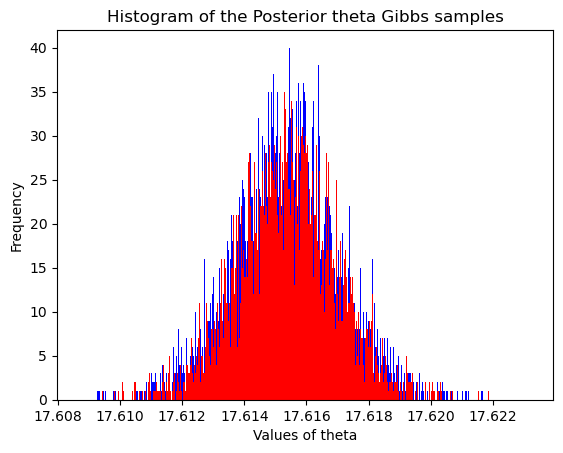

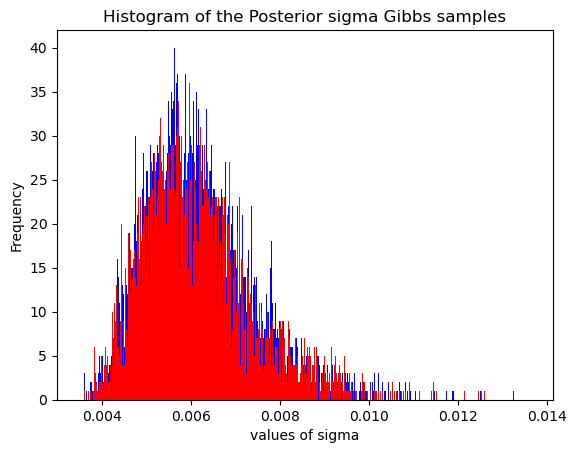

In [17]:
#Histogram of posterior theta samples for theta
import matplotlib.pyplot as plt
plt.hist(theta_Gibbs, bins = 500, color = 'blue')
plt.hist(theta_samples, bins = 500, color = 'red')
plt.xlabel('Values of theta')
plt.ylabel('Frequency')
plt.title('Histogram of the Posterior theta Gibbs samples')
plt.show();

plt.hist(sigma_Gibbs, bins = 500, color = 'blue')
plt.hist(sigma_samples, bins = 500, color = 'red')
plt.xlabel('values of sigma')
plt.ylabel('Frequency')
plt.title('Histogram of the Posterior sigma Gibbs samples')
plt.show();

An important fact in the above example is that for priors $\theta \in \text{Uniform}[-C, C]$ and $\log \sigma \sim \text{Uniform}[-C, C])$ when $C \rightarrow \infty$, the following is true: 
\begin{align*}
   \frac{\sqrt{n}(\bar{y} - \theta)}{\hat{\sigma}} \bigg \vert \text{data} \sim \mathbf{t}_{n-1}
\end{align*}

The proof of this result is technical and omitted (it is not difficult to prove however; one just needs to integrate the joint posterior of $\theta$ and $\sigma$ with respect to $\sigma$, and match the integrated density with the density of $\mathbf{t}_{n-1}$). This result means that the posterior distribution for $\theta$ (without any conditioning on $\sigma$) after centering by $\bar{y}$ and scaling by $\hat{\sigma}/\sqrt{n}$ is the Student $\mathbf{t}_{n-1}$ distribution. This  is similar to the result on which the usual frequentist inference is based. Thus frequentist and Bayesian inference with the flat priors coincide in this problem. Of course, if we change the priors by, say, making them informative, Bayes analysis will give answers different from the frequentist analysis.  

### Flat Priors in PyMC

In our Bayesian analysis, we have been using uninformative priors such as $\text{Uniform}[-80, 80]$ and $\text{Uniform}[-10, 10]$. One difficulty with such priors is that it is difficult to provide these ranges $[-80. 80]$ and  $[-10, 10]$ in  every problem. In PyMC, there is an alternative model specification called "Flat Distribution". The Flat distribution should be thought of as $\text{Uniform}[-C, C]$ as $C \rightarrow \infty$, and avoids the need to specify ranges for the uniform priors. Here is a solution of the normal mean estimation in PyMC using flat priors for $\theta$ and $\log \sigma$. 

In [18]:
import pymc as pm
import arviz as az
n = 15
y_obs = np.array([17.62, 17.61, 17.61, 17.62, 17.62, 17.615, 17.615, 17.625, 17.61, 17.62, 17.62, 17.605, 17.61, 17.62, 17.61])
measurement_model = pm.Model()
with measurement_model:
    theta = pm.Flat("theta") #now no range needs to be specified
    log_sigma = pm.Flat("log_sigma")
    sigma = pm.Deterministic("sigma", pm.math.exp(log_sigma))
    Y = pm.Normal("Y", mu = theta, sigma = sigma, observed=y_obs)
    #Sample from posterior:
    idata = pm.sample(2000, chains = 2, return_inferencedata = True) 

#The posterior samples can be used to estimate theta (and sigma) along with uncertainty quantification as follows: 
theta_samples = idata.posterior['theta'].values.flatten()
log_sigma_samples = idata.posterior['log_sigma'].values.flatten()
sigma_samples = np.exp(log_sigma_samples)
#Our best estimate of the unknown length can be taken to be the mean of the posterior samples for theta:
thetamean = np.mean(theta_samples)
display(thetamean)
#A 95% interval for theta based on the posterior samples is computed as follows:
lower_limit_theta = np.percentile(theta_samples, 2.5)
upper_limit_theta = np.percentile(theta_samples, 97.5)
display([lower_limit_theta, upper_limit_theta])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, log_sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


17.615348954770003

[17.61214643810097, 17.61861033323768]

## Gibbs Sampler in the more general Multivariate Case

The Gibbs sampler in the multivariate case also works similarly. Consider the problem of generating samples from a target density $f_{\text{Target}}(u)$ where $u$ is a multivariate vector. We decompose $u$ as 
\begin{align*}
   u = (u_{(1)}, \dots, u_{(k)}) 
\end{align*}
for $k$ subvectors $u_{(1)}, \dots, u_{(k)}$. Assume that $f_{\text{Target}}(u)$ is the joint density of $U_{(1)}, U_{(2)}, \dots, U_{(k)}$. The Gibbs sampler will produce samples of the form: 
\begin{align*}
   (u_{(1)}^{(0)}, \dots, u_{(k)}^{(0)}) \rightarrow (u_{(1)}^{(1)}, \dots, u_{(k)}^{(1)}) \rightarrow (u_{(1)}^{(2)}, \dots, u_{(k)}^{(2)}) \rightarrow \dots \rightarrow (u_{(1)}^{(T)}, \dots, u_{(k)}^{(T)})
\end{align*}
for a large $T$, by going through the following steps: 
1. Initialize at arbitrary $u_{(1)}^{(0)}, u_{(2)}^{(0)}, \dots, u_{(k)}^{(0)}$. Repeat the following for $t = 0, 1, 2, \dots$
2. Given the current sample $(u_{(1)}^{(t)}, u_{(2)}^{(t)}, \dots, u_{(k)}^{(t)})$, sample $u_{(j)}^{(t+1)}$ for $j = 1, \dots, k$ in order according to the conditional distribution of $U_{(j)}$ given $U_{(1)} = u_{(1)}^{(t+1)}, \dots, U_{(j-1)}^{(t+1)} = u_{(j-1)}^{(t+1)}, U_{(j)}^{(t)} = u_{(j)}^{(t)}, \dots, U_{(k)}^{(t)} = u_{(k)}^{(t)}$.

The components $U_{(1)}, \dots, U_{(k)}$ of $U$ are chosen so that the conditional distributions are easy to sample from. For a somewhat challenging exercise in Gibbs sampling, try to write down the Gibbs sampler for the Gaussian Mixture Models from last lecture. 

The Gibbs Sampler is an example of a Markov Chain Monte Carlo algorithm. Markov Chain here refers to the fact that the samples $(u_{(1)}^{(t)}, \dots, u_{(k)}^{(t)})$ generated by the Gibbs Sampler form a Markov Chain. The Gibbs Sampler can be seen as a special case of a more general class of algorithms called Metropolis-Hastings. 

# Linear Regression

We shall next study regression models including linear regression, logistic regression and other generalized linear models (GLMs). Today's focus will be on linear regression. 

The goal of regression is to understand the relationship between a response (or output or dependent) variable $y$ and $m$ covariates (or predictors or features or explanatory variables or inputs or independent variables) $x_1, \dots, x_m$. We observe data $(y_i, x_{i1}, \dots, x_{im})$ on the variables for each of $n$ units for $i = 1, \dots, n$. In linear regression, we assume the model:
\begin{align*}
   y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_m x_{im} + \epsilon_i
\end{align*}
for $i = 1, \dots, n$. Here $\beta_0, \beta_1, \dots, \beta_m$ are parameters of the model. $\beta_0$ is the intercept and $\beta_j$ is the regression coefficient for the $j^{th}$ variable $x_j$. It should be interpreted as the change in response ($y$) for a unit change in $x_j$ where all other variables are kept constant. The $\epsilon_i$ term represents error. In standard regression analysis, we assume $\epsilon_i \overset{\text{i.i.d}}{\sim} N(0, \sigma^2)$ for an unknown $\sigma$. So $\sigma$ will also be a parameter in the model. We thus have $m+2$ total parameters: $\beta_0, \beta_1, \dots, \beta_m, \sigma$. 

### Standard Frequentist Linear Regression Analysis

The coefficients $\beta_0, \dots, \beta_m$ are estimated by the method of least squares. More precisely, one finds $\hat{\beta}_0, \dots, \hat{\beta}_m$ which minimize
\begin{align*}
  S(\beta_0, \dots, \beta_m) = \sum_{i=1}^n \left(y_i - \beta_0 - \beta_1 x_{i1} - \dots - \beta_m x_{im} \right)^2
\end{align*}
over all values of $\beta_0, \dots, \beta_m$. The formula for the least squares estimator can be written down neatly using matrix notation. Let 
\begin{align*}
  Y =
  \begin{pmatrix}
    y_1 \\ \cdot \\ \cdot \\ \cdot \\ y_n
  \end{pmatrix}
  ~~\text{ and }~~
  X =
  \begin{pmatrix}
   1 & x_{11} & \cdot & \cdot & \cdot & x_{1m} \\ \cdot &  \cdot &
   \cdot & \cdot & \cdot & \cdot
   \\ \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\  1 & x_{i1} &
   \cdot & \cdot & \cdot & x_{im} \\ \cdot & \cdot &
   \cdot & \cdot & \cdot & \cdot \\ \cdot & \cdot & \cdot
   & \cdot & \cdot & \cdot\\ 1 & x_{n1} & \cdot & \cdot & \cdot & x_{nm}
 \end{pmatrix} ~~ \text{ and }~~
                                             \beta :=
\begin{pmatrix}
  \beta_0 \\ \beta_1 \\ \cdot \\ \cdot \\ \cdot \\ \beta_m
\end{pmatrix}
~~\text{ and }~~\hat{\beta} :=
\begin{pmatrix}
  \hat{\beta}_0 \\ \hat{\beta}_1 \\ \cdot \\ \cdot \\ \cdot \\ \hat{\beta}_m
\end{pmatrix}.
\end{align*}
Then the least squares estimator is given by
\begin{equation*}
  \hat{\beta} = (X^T X)^{-1} X^T Y.
\end{equation*}
In practice, this is computed by some library (such as statsmodels or scikit-learn). For quantifying the uncertainty in estimation, one uses the fact: 
\begin{align*}
   \hat{\beta} \sim N(\beta, \sigma^2 (X^T X)^{-1})   
\end{align*}
where the normal distribution on the right hand side is multivariate normal. This implies that each individual component (for $j = 0, 1, \dots, m$) of $\hat{\beta}$ satisfies 
\begin{align*}
   \hat{\beta}_j \sim N\left(\beta_j, \sigma^2 (X^T X)^{j+1, j+1} \right)
\end{align*}
where $(X^T X)^{j+1}$ is the $(j+1)^{th}$-diagonal entry of $(X^T X)^{-1}$. When $\sigma$ is unknown, the above relation **cannot** be used for inference on the beta-coefficients. In that case, one first estimates $\sigma$ by:
\begin{align*}
    \hat{\sigma} = \sqrt{\frac{\text{RSS}}{n-\text{rank}(X)}} ~~ \text{ where } ~~ \text{RSS} := \sum_{i=1}^n \left(y_i - \hat{\beta}_0 - \hat{\beta}_1 x_{i1} - \dots - \hat{\beta}_m x_{im} \right)^2
\end{align*}
RSS stands for Residual Sum of Squares. This estimate $\hat{\sigma}$ of $\sigma$ is known as the Residual Standard Error. Inference on $\beta_j$ can then be carried out via:
\begin{align*}
   \frac{\hat{\beta}_j - \beta_j}{\hat{\sigma} \sqrt{(X^T X)^{j+1, j+1}}} \sim \mathbf{t}_{n-\text{rank}(X)}
\end{align*}
Here is an illustration of linear regression in a standard dataset on heights. 

(1078, 2)
   Father   Son
0    65.0  59.8
1    63.3  63.2
2    65.0  63.3
3    65.8  62.8
4    61.1  64.3
5    63.0  64.2
6    65.4  64.1
7    64.7  64.0
8    66.1  64.6
9    67.0  64.0


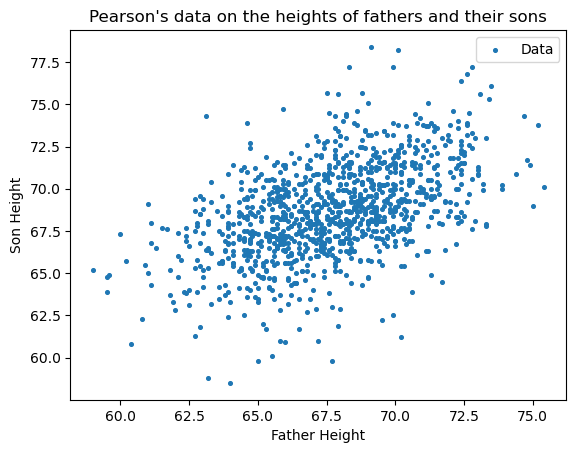

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2, multivariate_normal

#Pearson Height Data
height = pd.read_table("PearsonHeightData.txt")
print(height.shape)
n = len(height)
print(height.head(10))

#Plot the Data:
plt.scatter(height['Father'], height['Son'], label = 'Data', s = 7, alpha = 1)
plt.xlabel('Father Height')
plt.ylabel('Son Height')
plt.title("Pearson's data on the heights of fathers and their sons")
plt.legend()
plt.show()

In [20]:
#Linear Regression using the library statsmodels
import statsmodels.api as sm
X = sm.add_constant(height['Father'])
print(X.head(10))
model = sm.OLS(height['Son'], X).fit()
print(model.summary())
#This summary gives the least squares estimates
#The standard error corresponding to each estimate of beta_j is simply \hat{\sigma} \sqrt{(X^T X)^{j+1, j+1}}

   const  Father
0    1.0    65.0
1    1.0    63.3
2    1.0    65.0
3    1.0    65.8
4    1.0    61.1
5    1.0    63.0
6    1.0    65.4
7    1.0    64.7
8    1.0    66.1
9    1.0    67.0
                            OLS Regression Results                            
Dep. Variable:                    Son   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     360.9
Date:                Wed, 27 Sep 2023   Prob (F-statistic):           1.27e-69
Time:                        06:40:53   Log-Likelihood:                -2489.4
No. Observations:                1078   AIC:                             4983.
Df Residuals:                    1076   BIC:                             4993.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef  

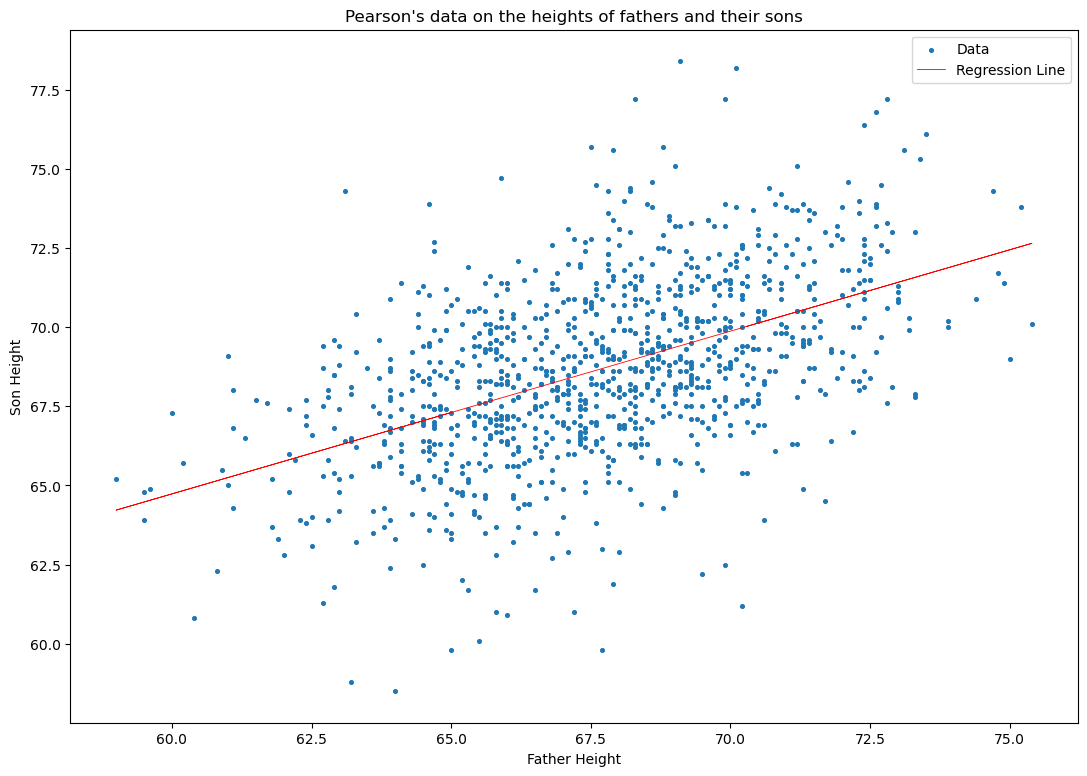

In [21]:
#Plotting the regression line on the scatterplot of the data:
plt.figure(figsize = (13, 9))
plt.scatter(height['Father'], height['Son'], label = 'Data', s = 7, alpha = 1)
plt.plot(height['Father'], model.predict(X), color = 'red', label = 'Regression Line', linewidth = 0.6)
plt.xlabel('Father Height')
plt.ylabel('Son Height')
plt.title("Pearson's data on the heights of fathers and their sons")
plt.legend()
plt.show()

In [22]:
#Residual Standard Error:
residuals = height['Son'] - model.predict(X)
sighat = np.sqrt(np.sum(residuals**2) / (n - 2))
print(sighat)

2.4381343793524275


In [23]:
#Standard Errors of Regression Coefficient Estimates: 
#As mentioned, the standard error corresponding to each estimate of beta_j is 
#simply \hat{\sigma} \sqrt{(X^T X)^{j+1, j+1}}. We verify this here
X_matrix = np.column_stack([np.ones(n), height['Father']])
Sigma_mat = (sighat**2) * np.linalg.inv(X_matrix.T @ X_matrix)
stderrs = np.sqrt(np.diag(Sigma_mat))
print("Standard Errors:", stderrs)

Standard Errors: [1.83289458 0.02705681]


### Standard Bayesian Linear Regression Analysis

Standard Bayesian Analysis for Linear Regression works with Flat Priors for each $\beta_j$ as well as for $\log \sigma$. In other words, we assume 
\begin{align*}
   \beta_0, \beta_1, \dots, \beta_m, \log \sigma \overset{\text{i.i.d}}{\sim} \text{Uniform}[-C, C]
\end{align*}
for a large $C \rightarrow \infty$. With this prior, it can be proved mathematically that Bayesian analysis leads to **exactly** the same results as the standard frequentist analysis. More specifically, it can be shown that for each $j = 0, 1, \dots, m$,
\begin{align*}
   \frac{\hat{\beta}_j - \beta_j}{\hat{\sigma} \sqrt{(X^T X)^{j+1, j+1}}} \bigg \vert \text{data}\sim \mathbf{t}_{n-\text{rank}(X)}
\end{align*}
We can verify that the Bayesian analysis leads to the same results as the standard frequentist analysis easily in PyMC. 

In [24]:
#Bayesian Linear Regression through PyMC
linregmod = pm.Model()
with linregmod:
    # Priors for unknown model parameters
    b0 = pm.Flat("b0")
    b1 = pm.Flat("b1")
    log_sigma = pm.Flat("log_sigma")
    sigma = pm.Deterministic("sigma", pm.math.exp(log_sigma))
    # Expected value of outcome
    mu = b0 + b1 * height['Father']
    # Likelihood
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=height['Son'])
    idata = pm.sample(2000, chains = 2, return_inferencedata = True)  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b0, b1, log_sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 36 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [25]:
b0_samples = idata.posterior['b0'].values.flatten()
b1_samples = idata.posterior['b1'].values.flatten()
log_sigma_samples = idata.posterior['log_sigma'].values.flatten()
sigma_samples = np.exp(log_sigma_samples)

display([np.mean(b0_samples), np.std(b0_samples)])
display([np.mean(b1_samples), np.std(b1_samples)])
display([np.mean(sigma_samples)])
#These numbers should be close to the numbers reported in the regression summary i.e., the Bayesian solution gives very similar answers to the frequentist solution

[33.86810381464156, 1.7941241869415936]

[0.5143727295018246, 0.026504803219881835]

[2.4406882013518363]

One advantage of the Bayesian analysis is that posterior uncertainty in the regression line can be visualized by plotting the lines corresponding to the different posterior sampled values of $\beta_0, \beta_1, \dots, \beta_m$. This is done in the code below. 

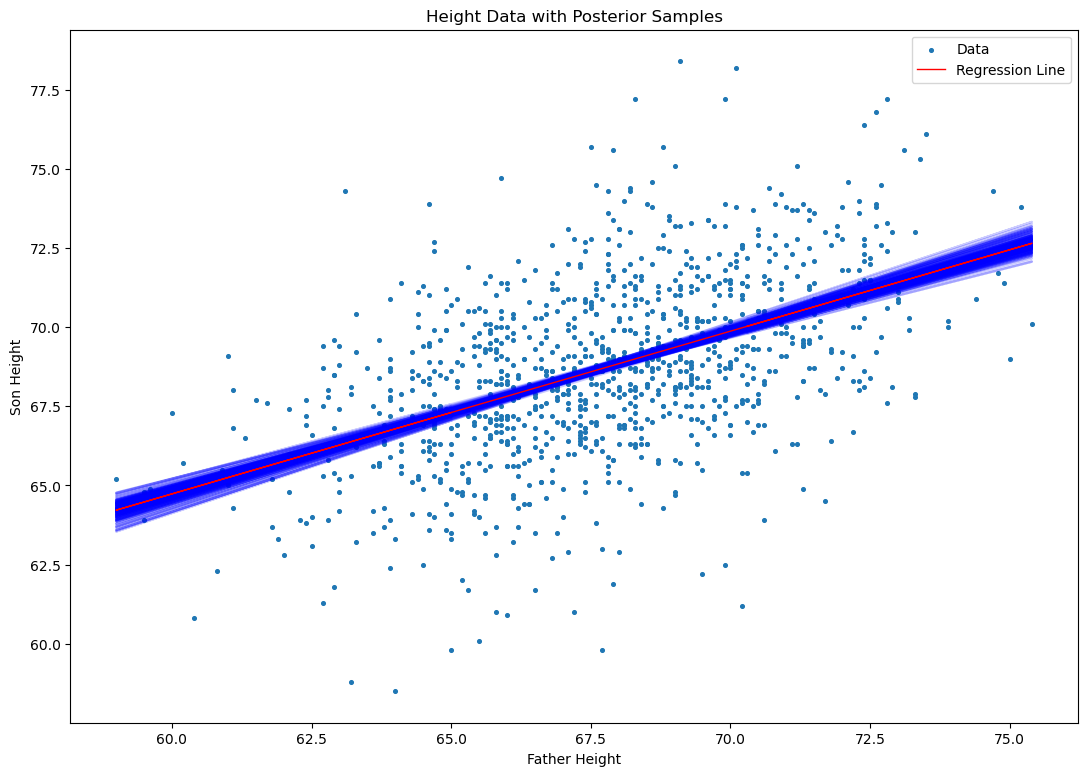

In [26]:
# Visualizing posterior variability
N = 200
# Plotting the data, regression line, and posterior samples
plt.figure(figsize = (13, 9))
plt.scatter(height['Father'], height['Son'], label='Data', alpha=1, s = 7)
for k in range(N):
    plt.plot(height['Father'], b0_samples[k] + b1_samples[k]*height['Father'], color='blue', alpha=0.2)
plt.plot(height['Father'], model.predict(X), color='red', label='Regression Line', linewidth = 1)
plt.xlabel('Father Height')
plt.ylabel('Son Height')
plt.title("Height Data with Posterior Samples")
plt.legend()
plt.show()
#Generally the posterior in linear regression will be quite narrow

Next we use linear regression on another dataset of the population of the United States for each month from 1959 to 2022. We fit a line to the population as a function of time. 

In [27]:
#US Population Example:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from numpy.linalg import inv
import pymc as pm

          DATE    POPTHM
0   1959-01-01  175818.0
1   1959-02-01  176044.0
2   1959-03-01  176274.0
3   1959-04-01  176503.0
4   1959-05-01  176723.0
5   1959-06-01  176954.0
6   1959-07-01  177208.0
7   1959-08-01  177479.0
8   1959-09-01  177755.0
9   1959-10-01  178026.0
10  1959-11-01  178273.0
11  1959-12-01  178504.0
12  1960-01-01  178925.0
13  1960-02-01  179326.0
14  1960-03-01  179707.0
           DATE    POPTHM
747  2021-04-01  331963.0
748  2021-05-01  332008.0
749  2021-06-01  332092.0
750  2021-07-01  332192.0
751  2021-08-01  332295.0
752  2021-09-01  332403.0
753  2021-10-01  332513.0
754  2021-11-01  332598.0
755  2021-12-01  332640.0
756  2022-01-01  332684.0
757  2022-02-01  332750.0
758  2022-03-01  332812.0
759  2022-04-01  332863.0
760  2022-05-01  332928.0
761  2022-06-01  333028.0
(762, 2)


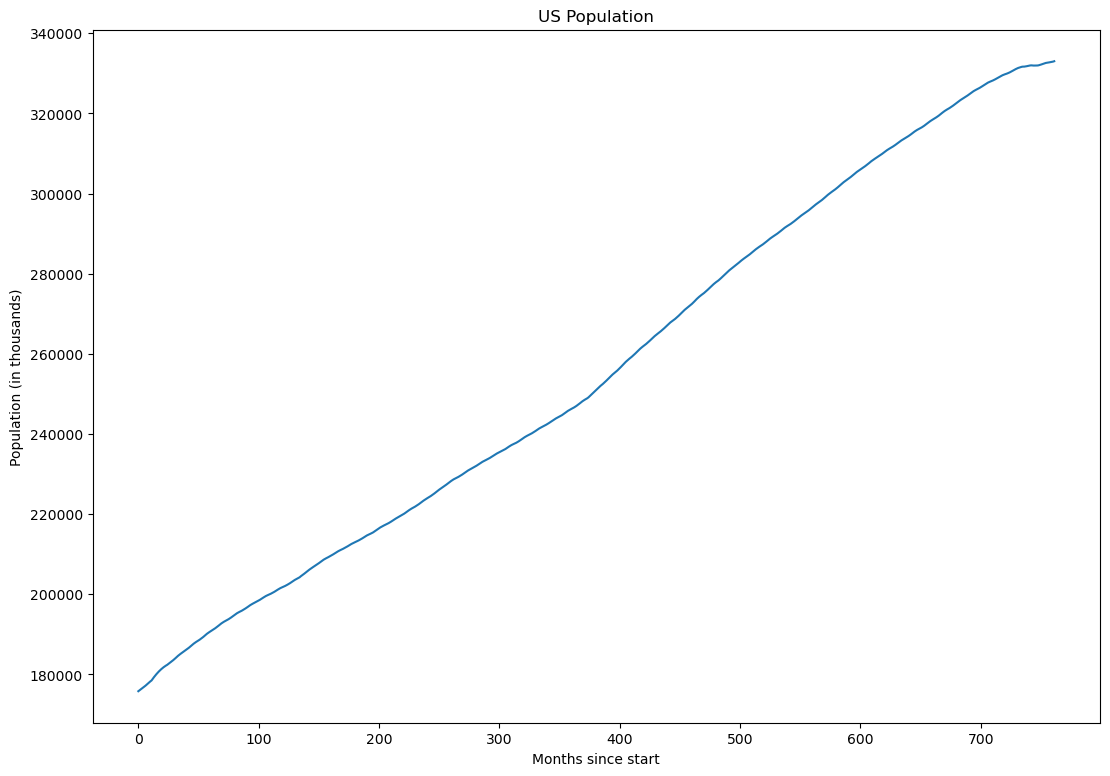

In [28]:
# Read data
uspop_raw = pd.read_csv("POPTHM.csv")
print(uspop_raw.head(15))
print(uspop_raw.tail(15))
print(uspop_raw.shape)
#Monthly Data downloaded from FRED. 
#Data given for each month equals the average of the estimated population on the first day of the month
#and the first day of the next month. 
#The units are thousands of dollars so 200,000 actually refers to 200 million. 

# Plot raw data
plt.figure(figsize=(13, 9))
plt.plot(uspop_raw['POPTHM'])
plt.ylabel('Population (in thousands)')
plt.xlabel('Months since start')
plt.title('US Population')
plt.show()

In [29]:
#Linear Regression of Population with Time
time = np.arange(1, uspop_raw.shape[0] + 1)
X = sm.add_constant(time)
lin_model = sm.OLS(uspop_raw['POPTHM'], X).fit()
print(lin_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 POPTHM   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 2.394e+05
Date:                Wed, 27 Sep 2023   Prob (F-statistic):               0.00
Time:                        06:41:53   Log-Likelihood:                -7090.6
No. Observations:                 762   AIC:                         1.419e+04
Df Residuals:                     760   BIC:                         1.419e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.742e+05    193.211    901.647      0.0

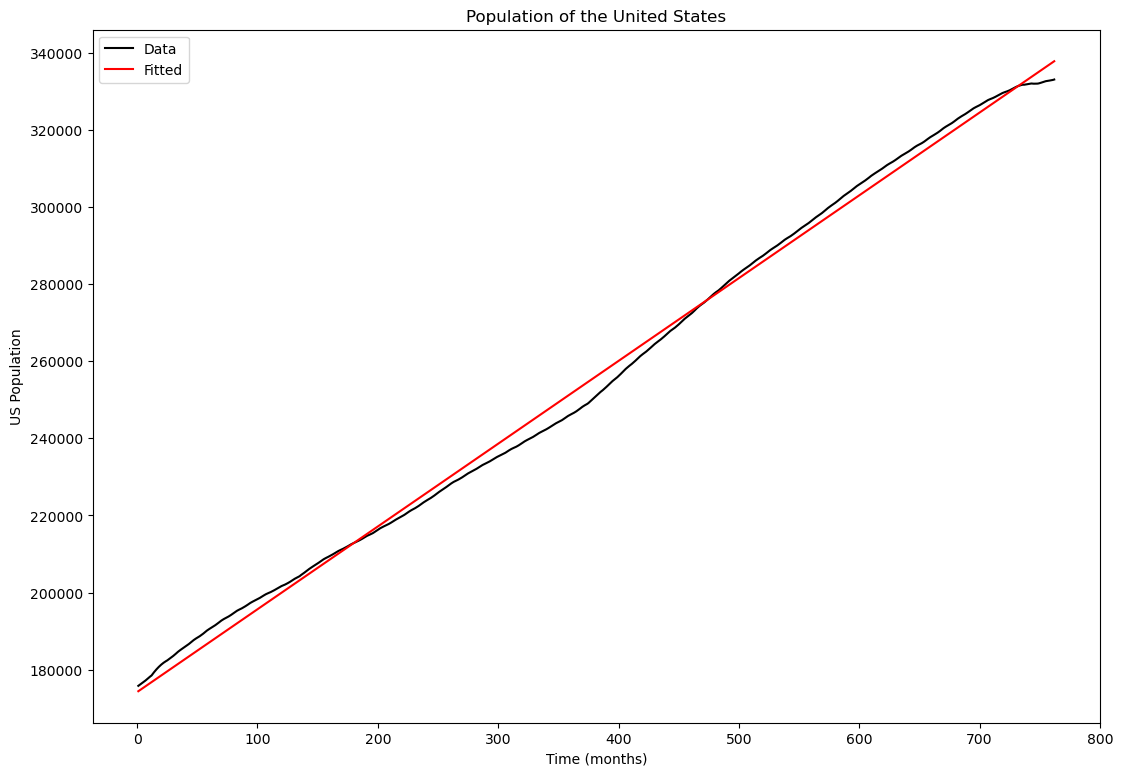

In [30]:
#Plot data with the fitted regression line:
plt.figure(figsize=(13, 9))
plt.plot(time, uspop_raw['POPTHM'], label="Data", color="black")
plt.plot(time, lin_model.fittedvalues, color="red", label="Fitted")
plt.ylabel('US Population')
plt.xlabel('Time (months)')
plt.title('Population of the United States')
plt.legend()
plt.show()

In [31]:
#Estimate of sigma
n = uspop_raw.shape[0]
sighat = np.sqrt(sum(lin_model.resid**2) / (n-2))
#Standard Errors of estimates:
stderrs = lin_model.bse

# Compute variance-covariance matrix
X_matrix = np.column_stack([np.ones(len(time)), time])
Sigma_mat = sighat**2 * inv(X_matrix.T @ X_matrix)

# Print relevant statistics
print("Residual Standard Error:", sighat)
print("Standard Errors from Model:", stderrs)
print("Variance-Covariance Matrix:", Sigma_mat)
print("Standard Errors from Matrix:", np.sqrt(np.diag(Sigma_mat)))

Residual Standard Error: 2664.107143206883
Standard Errors from Model: const    193.210975
x1         0.438743
dtype: float64
Variance-Covariance Matrix: [[ 3.73304810e+04 -7.34370117e+01]
 [-7.34370117e+01  1.92495444e-01]]
Standard Errors from Matrix: [193.21097524   0.43874303]


In [32]:
#Bayesian Inference for Regression
linregmod = pm.Model()
with linregmod:
    # Priors for unknown model parameters
    b0 = pm.Flat("b0")
    b1 = pm.Flat("b1")
    log_sigma = pm.Flat("log_sigma")
    sigma = pm.Deterministic("sigma", pm.math.exp(log_sigma))
    # Expected value of outcome
    mu = b0 + b1 * time
    # Likelihood
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=uspop_raw['POPTHM'])
    idata = pm.sample(3000, chains = 2, return_inferencedata = True)  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b0, b1, log_sigma]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [33]:
b0_samples = idata.posterior['b0'].values.flatten()
b1_samples = idata.posterior['b1'].values.flatten()
log_sigma_samples = idata.posterior['log_sigma'].values.flatten()
sigma_samples = np.exp(log_sigma_samples)

display([np.mean(b0_samples), np.std(b0_samples)])
display([np.mean(b1_samples), np.std(b1_samples)])
display([np.mean(sigma_samples)])

[174205.95021198844, 194.37477573088697]

[214.65493675525587, 0.4387291926538981]

[2665.8235383769716]

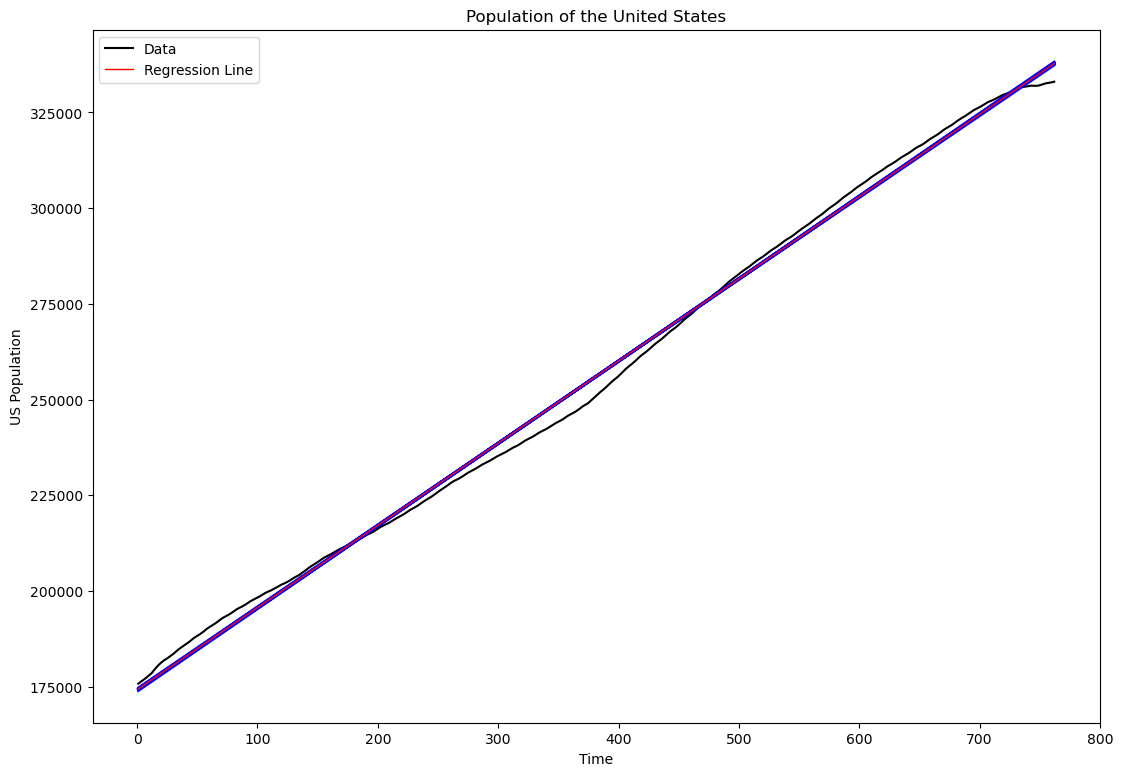

In [34]:
# Visualizing posterior variability
N = 200
# Plotting the data, regression line, and posterior samples
plt.figure(figsize = (13, 9))
plt.plot(time, uspop_raw['POPTHM'], label='Data', color = 'black')
for k in range(N):
    plt.plot(time, b0_samples[k] + b1_samples[k]*time, color='blue', alpha=0.2)
plt.plot(time, lin_model.predict(X), color='red', label='Regression Line', linewidth = 1)
plt.xlabel('Time')
plt.ylabel('US Population')
plt.title("Population of the United States")
plt.legend()
plt.show()

In both the above examples, the posterior variability in the regression lines seems quite narrow. This turns to be a general phenomenon in that the variability around the regression line is generally narrow. This can even happen when the linear model is not the correct model as illustrated in the simple simulated example below. 

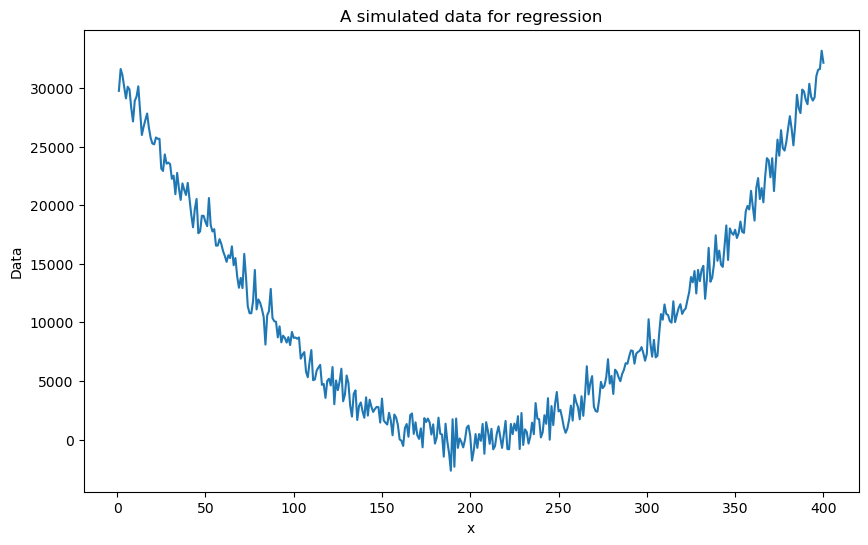

In [35]:
#Here is a simulated example
n = 400
x = np.arange(1, n+1)
sig = 1000
dt = 5 + 0.8 * ((x-(n/2)) ** 2) + sig * np.random.randn(n)
plt.figure(figsize = (10, 6))
plt.plot(x, dt)
plt.xlabel("x")
plt.ylabel("Data")
plt.title("A simulated data for regression")
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.03137
Date:                Wed, 27 Sep 2023   Prob (F-statistic):              0.859
Time:                        06:42:10   Log-Likelihood:                -4234.8
No. Observations:                 400   AIC:                             8474.
Df Residuals:                     398   BIC:                             8482.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.053e+04    962.807     10.939      0.0

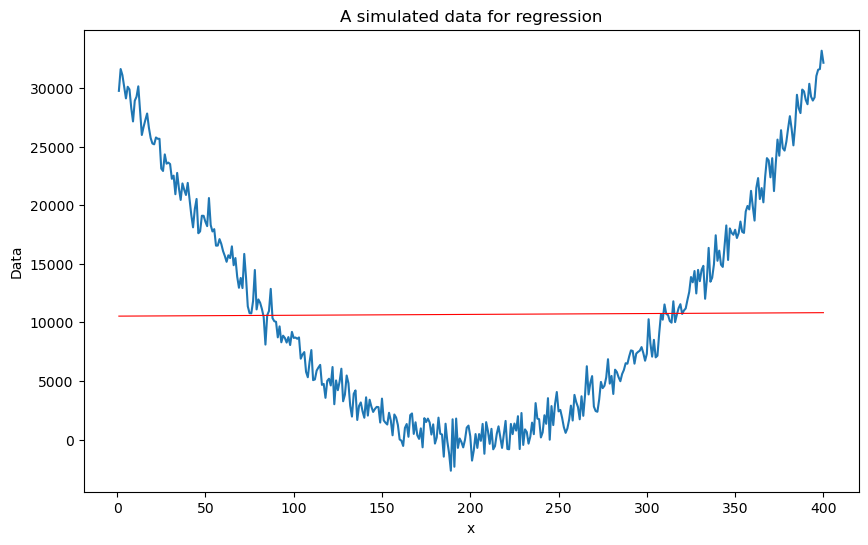

In [36]:
#Fitting a line to the above data
X = sm.add_constant(x)
lin_model = sm.OLS(dt, X).fit()
print(lin_model.summary())
residuals = dt - lin_model.predict(X)
sighat = np.sqrt(np.sum(residuals**2) / (n - 2))
print(sighat)

plt.figure(figsize = (10, 6))
plt.plot(x, dt)
plt.plot(x, lin_model.fittedvalues, color = "red", label = "Linear Fit", linewidth = 0.8)
plt.xlabel("x")
plt.ylabel("Data")
plt.title("A simulated data for regression")
plt.show()

Let us now fit the Bayesian linear regression model (with flat priors) and then obtain posterior samples from beta_0 and beta_1.

In [37]:
#Bayesian Linear Regression through PyMC
linregmod = pm.Model()
with linregmod:
    # Priors for unknown model parameters
    b0 = pm.Flat("b0")
    b1 = pm.Flat("b1")
    log_sigma = pm.Flat("log_sigma")             
    sigma = pm.Deterministic("sigma", pm.math.exp(log_sigma))
    # Expected value of outcome
    mu = b0 + b1 * x
    # Likelihood
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=dt)
    idata = pm.sample(2000, chains = 2, return_inferencedata = True)  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b0, b1, log_sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


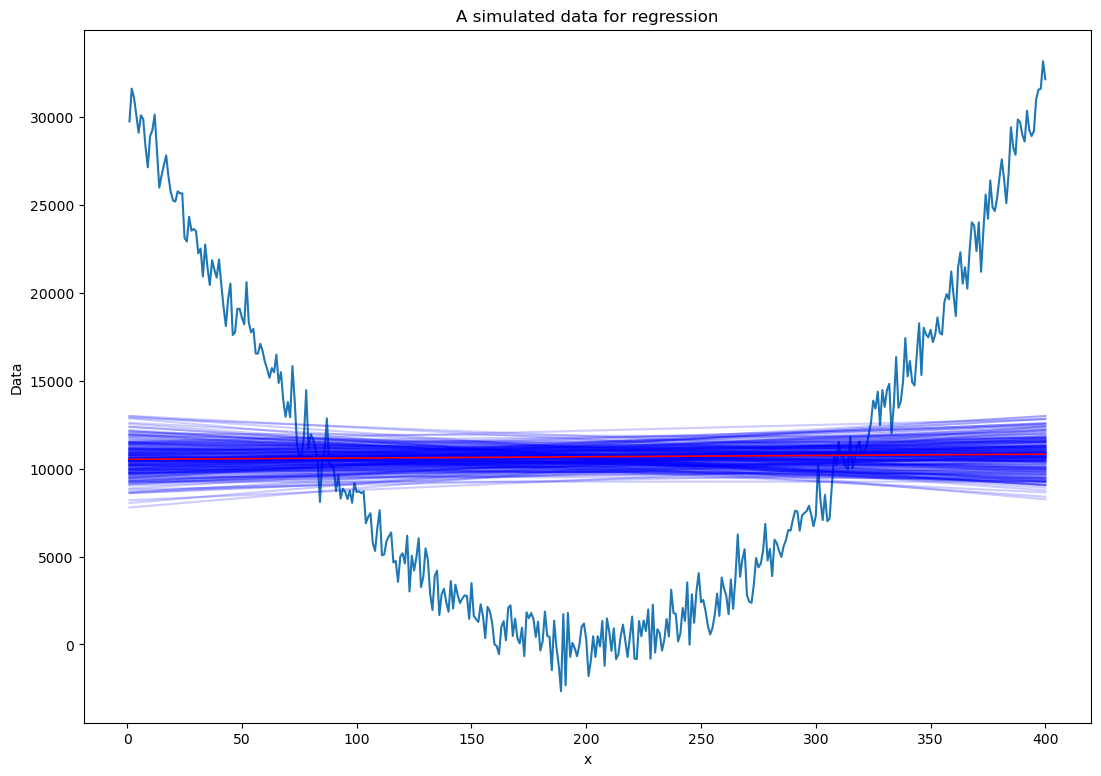

In [38]:
b0_samples = idata.posterior['b0'].values.flatten()
b1_samples = idata.posterior['b1'].values.flatten()
N = 200
plt.figure(figsize = (13, 9))
plt.plot(x, dt)
for k in range(N):
    plt.plot(x, b0_samples[k] + b1_samples[k] * x, color='blue', alpha=0.2)
plt.plot(x, lin_model.fittedvalues, color = "red", label = "Linear Fit", linewidth = 1.2)
plt.xlabel("x")
plt.ylabel("Data")
plt.title("A simulated data for regression")
plt.show()
#Clearly the posterior lines are tightly clustered around the fitted regression line.

In this problem, the correct model to fit is a quadratic function of time to the population data. This can also be handled by the linear regression methodology simply because a quadratic function of $t = \text{time}$ is simply of the form $\beta_0 + \beta_1 t + \beta_2 t^2$ which is a linear function of $1, t$ and $t^2$. So if we take $t$ and $t^2$ to be two covariates $x_1$ and $x_2$, we can fit this quadratic function in the same linear regression framework. This is illustrated in the code below. 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 1.761e+04
Date:                Wed, 27 Sep 2023   Prob (F-statistic):               0.00
Time:                        06:42:34   Log-Likelihood:                -3335.5
No. Observations:                 400   AIC:                             6677.
Df Residuals:                     397   BIC:                             6689.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.201e+04    153.144    209.004      0.0

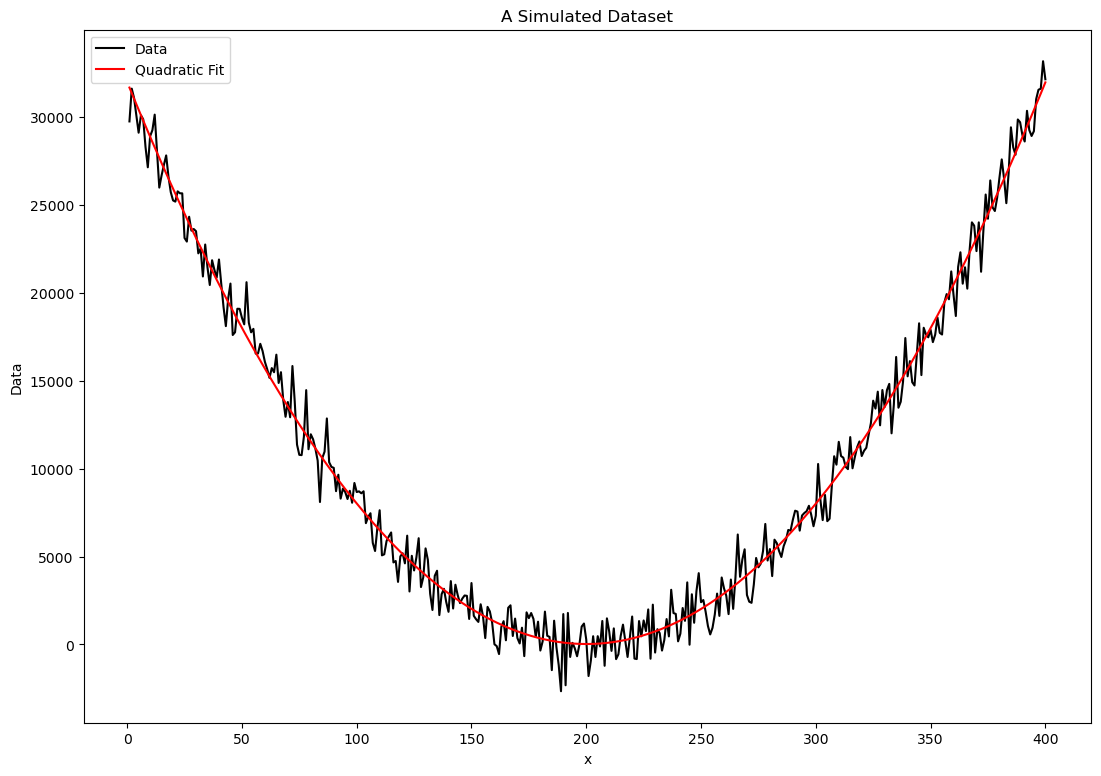

In [39]:
#Now let us fit a quadratic function to this dataset:
X = sm.add_constant(np.column_stack([x, x**2]))  # Adds constant term (for intercept) and quadratic term
quad_model = sm.OLS(dt, X).fit()
print(quad_model.summary())
residuals = dt - quad_model.predict(X)
sighat = np.sqrt(np.sum(residuals**2) / (n - 3))
print(sighat)

#Plotting
plt.figure(figsize=(13, 9))
plt.plot(x, dt, label="Data", color="black")
plt.plot(x, quad_model.fittedvalues, color="red", label="Quadratic Fit")
plt.xlabel("x")
plt.ylabel("Data")
plt.title("A Simulated Dataset")
plt.legend()
plt.show()


In [40]:
#Bayesian quadratic fitting:
quadregmod = pm.Model()
with quadregmod:
    # Priors for unknown model parameters
    b0 = pm.Flat("b0")
    b1 = pm.Flat("b1")
    b2 = pm.Flat("b2")
    log_sigma = pm.Flat("log_sigma")             
    sigma = pm.Deterministic("sigma", pm.math.exp(log_sigma))
    # Expected value of outcome
    mu = b0 + b1 * x + b2 * (x ** 2)
    # Likelihood
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=dt)
    idata = pm.sample(2000, chains = 2, return_inferencedata = True)  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b0, b1, b2, log_sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


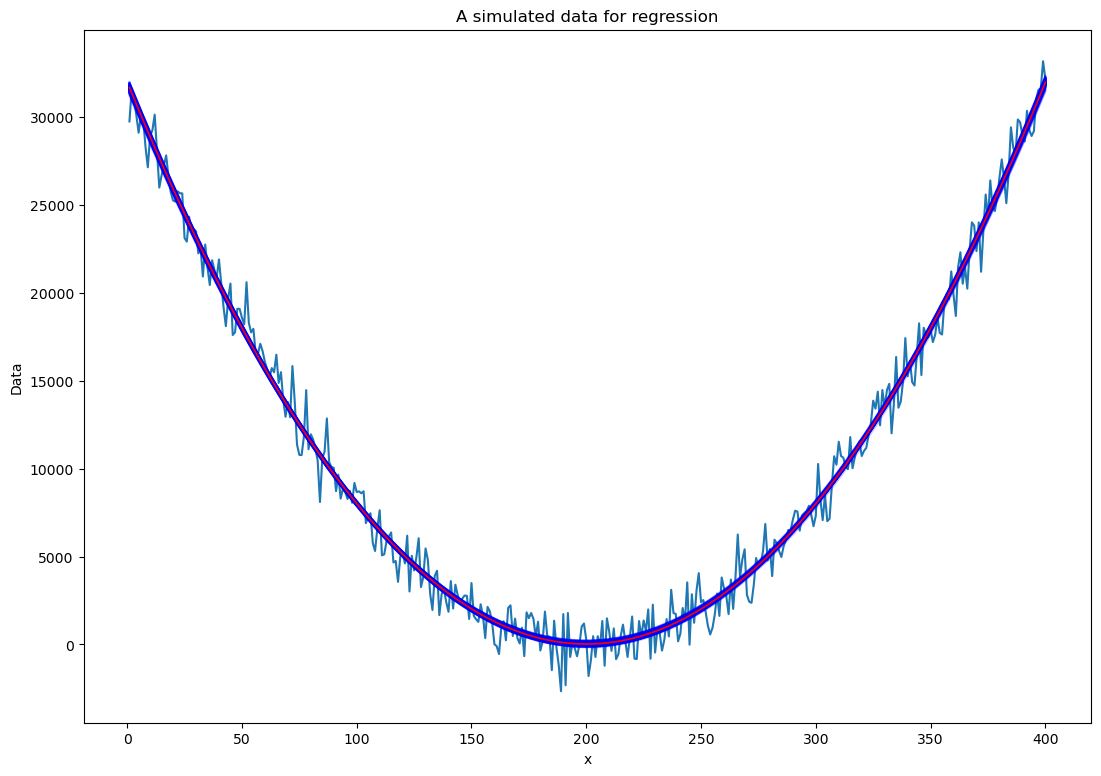

In [41]:
b0_samples = idata.posterior['b0'].values.flatten()
b1_samples = idata.posterior['b1'].values.flatten()
b2_samples = idata.posterior['b2'].values.flatten()
N = 200
plt.figure(figsize = (13, 9))
plt.plot(x, dt)
for k in range(N):
    plt.plot(x, b0_samples[k] + b1_samples[k] * x + b2_samples[k] * (x ** 2), color='blue', alpha=0.2)
plt.plot(x, quad_model.fittedvalues, color = "red", label = "Linear Fit", linewidth = 1.2)
plt.xlabel("x")
plt.ylabel("Data")
plt.title("A simulated data for regression")
plt.show()

Next we present an example where a more complicated function can be fit for the relation between $y$ and $x$ using the linear regression methodology. In this data, $x$ represents time (in months from January 1992 to August 2022), and $y$ represent the monthly sales numbers of alcohol. The function is plotted in the code below. 

           DATE  MRTSSM4453USN
362  2022-03-01           5590
363  2022-04-01           5710
364  2022-05-01           5919
365  2022-06-01           6038
366  2022-07-01           6230


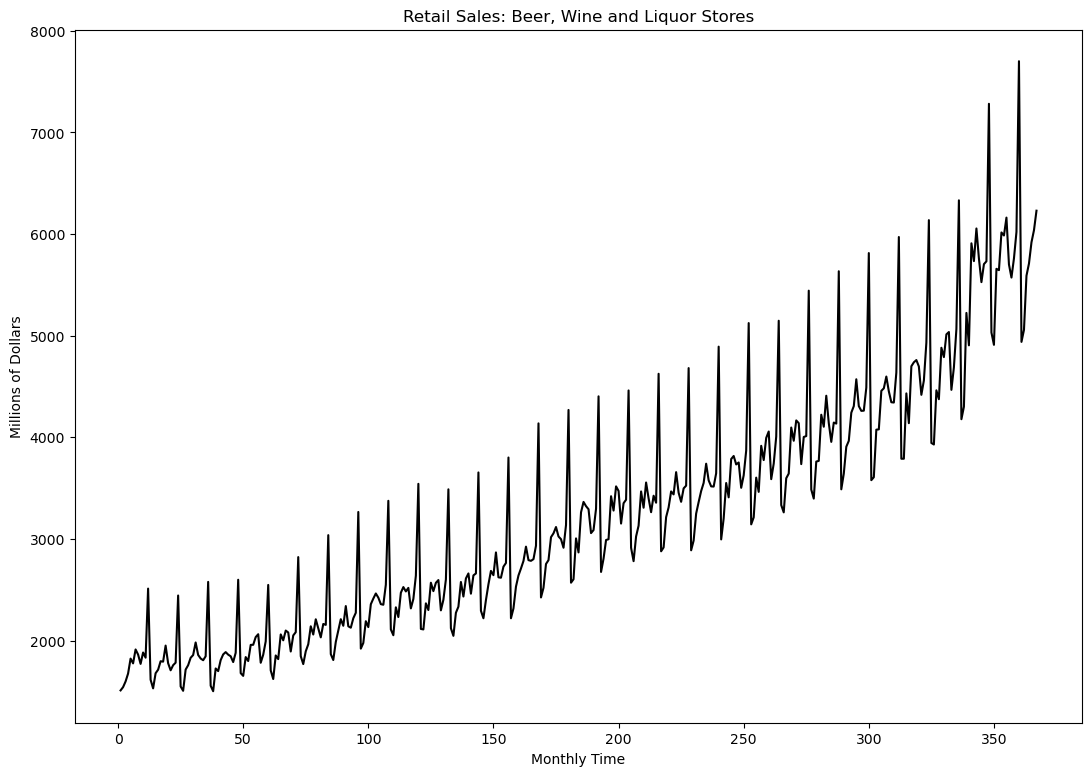

In [42]:
#Another illustration of linear regression
sales_raw = pd.read_csv("MRTSSM4453USN.csv")
#This dataset gives monthly data on beer, wine and liquor sales in the US from January 1992 to August 2022
print(sales_raw.tail())

dt = sales_raw.iloc[:, 1].values

# Plot the data
time = np.arange(1, len(dt) + 1)
plt.figure(figsize=(13, 9))
plt.plot(time, dt, label="Data", color="black")
plt.xlabel("Monthly Time")
plt.ylabel("Millions of Dollars")
plt.title("Retail Sales: Beer, Wine and Liquor Stores")
plt.show()

This dataset shows an increasing trend that can perhaps be modeled by a linear or quadratic function of time. It also shows a seasonal pattern. One way to capture this relationship is to fit the model: 
\begin{align*}
  y_i &= \beta_0 + \beta_1 \cos \left(2 \pi \frac{t_i}{12} \right) + \beta_2 \sin \left(2 \pi \frac{t_i}{12} \right)\\ &+ \beta_3 \cos \left(2 \pi \frac{2t_i}{12} \right) + \beta_4 \sin \left(2 \pi \frac{2t_i}{12} \right) \\ &+ \beta_5 \cos \left(2 \pi \frac{3t_i}{12} \right) + \beta_6 \sin \left(2 \pi \frac{3t_i}{12} \right) \\ &+ \beta_7 \cos \left(2 \pi \frac{4t_i}{12} \right) + \beta_8 \sin \left(2 \pi \frac{4t_i}{12} \right) + \beta_9 t_i + \beta_{10} t_i^2 + \epsilon_i
\end{align*}
The cosine and sine terms capture the seasonal pattern in the dataset and the increasing pattern is captured by the quadratic term. This is again a linear regression model with $m = 10$. It can be fit in the same way as follows. 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     648.5
Date:                Wed, 27 Sep 2023   Prob (F-statistic):          1.15e-221
Time:                        06:43:07   Log-Likelihood:                -2591.1
No. Observations:                 367   AIC:                             5204.
Df Residuals:                     356   BIC:                             5247.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1797.3211     45.085     39.865      0.0

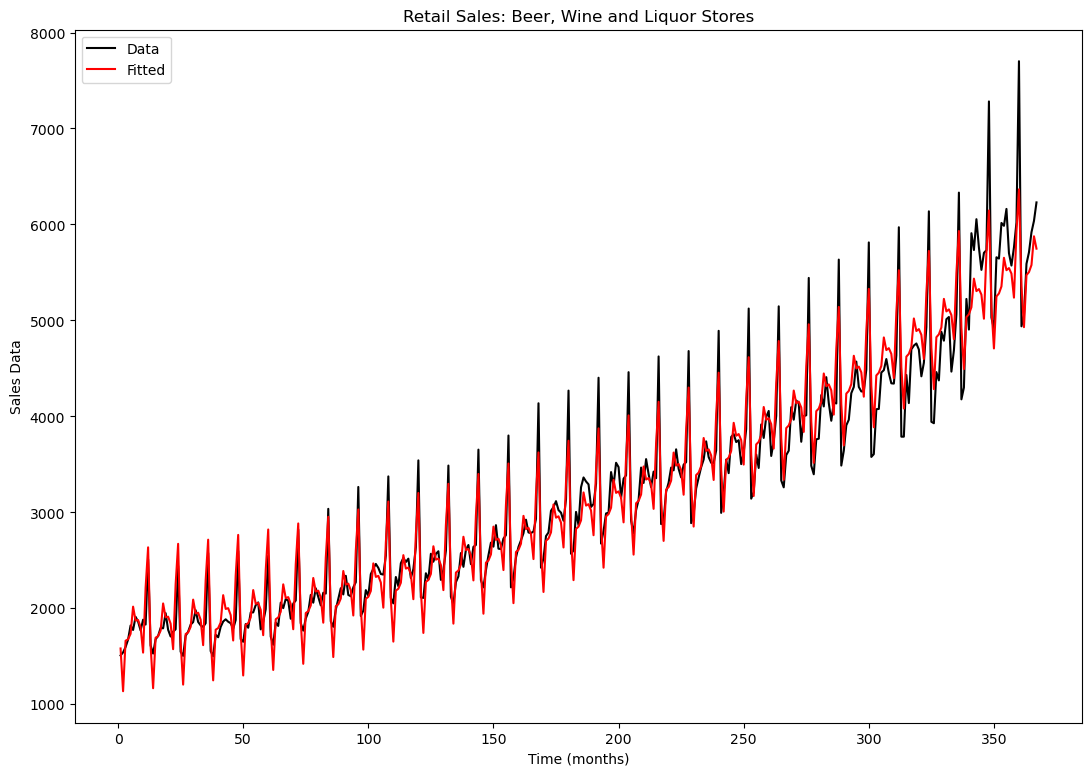

In [43]:
# Construct harmonic regression terms and quadratic terms
t = time
d = 12
v1 = np.cos(2 * np.pi * 1 * t / d)
v2 = np.sin(2 * np.pi * 1 * t / d)
v3 = np.cos(2 * np.pi * 2 * t / d)
v4 = np.sin(2 * np.pi * 2 * t / d)
v5 = np.cos(2 * np.pi * 3 * t / d)
v6 = np.sin(2 * np.pi * 3 * t / d)
v7 = np.cos(2 * np.pi * 4 * t / d)
v8 = np.sin(2 * np.pi * 4 * t / d)
v9 = t
v10 = t**2

# Fit the regression model
X = sm.add_constant(np.column_stack([v1, v2, v3, v4, v5, v6, v7, v8, v9, v10]))
lin_mod = sm.OLS(dt, X).fit()
print(lin_mod.summary())

# Plot original and fitted data
plt.figure(figsize=(13, 9))
plt.plot(t, dt, label="Data", color="black")
plt.plot(t, lin_mod.fittedvalues, color="red", label="Fitted")
plt.xlabel("Time (months)")
plt.ylabel("Sales Data")
plt.title("Retail Sales: Beer, Wine and Liquor Stores")
plt.legend()
plt.show()